In [1]:
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
import numpy as np

import matplotlib as plt

from pylab import *

import tensorflow as tf

In [2]:
import scipy as sc
!pip install tensorly
import tensorly as tl


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
def reduce_image (image, n):
    # method to compute PCA of 'image' for 'n' components and displays reduced image
    
    # initialize image as array
    image_1 = np.asarray(image)
    
    # initialize PCA with desired component number
    pca = PCA(n_components = n)
    
    # find 'n' principal components
    reduced_image_1 = pca.fit_transform(image_1)
    
    # reconstruct image from principal components
    reconstructed_image_1 = pca.inverse_transform(reduced_image_1)
    
    # show reduced image in grayscale
    imshow(reconstructed_image_1, cmap = 'gray')
    title(str(n) + ' principal components')
    show()
    
    return None

In [4]:
def apply_reconstruction(image1, image2, n):
    # this method takes the PCA of image1, and uses it to reconstruct image1 and image2
    
    # initialize image as array
    image_1 = np.asarray(image1)
    image_2 = np.asarray(image2)
    
    # initialize PCA with desired component number
    pca = PCA(n_components = n)
    
    image_1_components = pca.fit(image_1)
    
    # tranform image1 with its principal components
    reduced_image_1 = pca.transform(image_1)
    
    # reconstruct image1 from its principal components
    reconstructed_image_1 = pca.inverse_transform(reduced_image_1)
    
    # tranform image2 with image2 principal components
    reduced_image_2 = pca.transform(image_2)
    
    # reconstruct image2 from image1 principal components
    reconstructed_image_2 = pca.inverse_transform(reduced_image_2)
    
    
    f = plt.figure()
    f.add_subplot(1, 3, 1)
    
    # show reduced image1 in grayscale
    imshow(reconstructed_image_1, cmap = 'gray')
    title(str(n) + ' own components')
    
    
    f.add_subplot(1, 3, 2)
    
    # show reduced image2 in grayscale
    imshow(reconstructed_image_2, cmap = 'gray')
    title(str(n) + ' not own components')
    
    f.add_subplot(1, 3, 3)
    reduce_image(image2, n)
    
    f.tight_layout()
    show(block = True)
    
    return None

In [5]:
# fetching olivetti faces data
image_data = fetch_olivetti_faces()

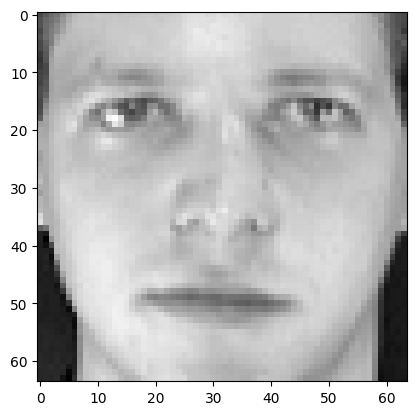

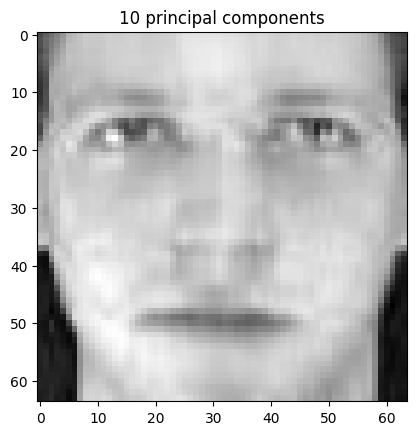

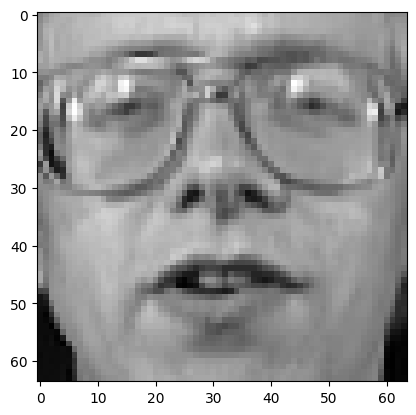

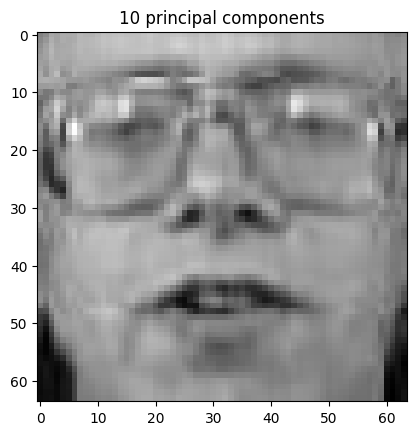

In [6]:
# testing pca for two images

test1 = image_data.images[0]
imshow(test1, cmap = 'gray')
show()

reduce_image(test1, 10)

test2 = image_data.images[10]

imshow(test2, cmap = 'gray')
show()

reduce_image(test2, 10)


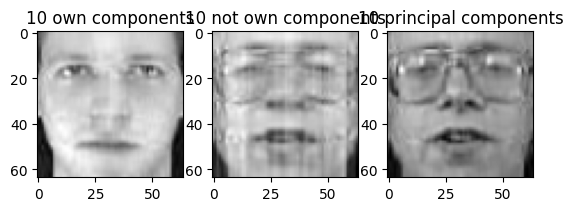

In [7]:
# testing what happens if you use one image's pca to reconstruct another image

# using the principal components of one image to reconstruct another image
apply_reconstruction(test1, test2, 10)

In [8]:
# since the dataset is made out of 10 pictures of every person, I am taking only one picture for every person
# as the training data

faces = image_data.images[0:np.shape(image_data.images)[0] - 1:10, :, : ]

# Begin Here!!

#### Everything previous was just me testing to get a good data set. The data is a series of images of closeups of different peoples' faces. Each image is (64 x 64), and there are 40 images of different people in total.

#### the variable "faces" is a (40, 64, 64) array, where the first index iterates through different faces, so to see one face, you would code:
    imshow(faces[0], cmap = 'gray')

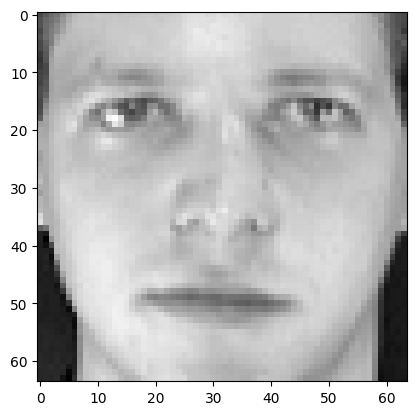

In [9]:
# showing the first face
imshow(faces[0], cmap = 'gray')

In [10]:
# create tensorly tensor from faces
x = tl.tensor(faces)

# calculate unfolded tensors to use for CP factorization
x_1 = tl.unfold(x, 0)
x_2 = tl.unfold(x, 1)
x_3 = tl.unfold(x, 2)


# initialize A, B, C

A_0 = tl.random.random_cp((40, 64), rank = 64, full = True)
B_0 = tl.random.random_cp((64, 64), rank = 64, full = True)
C_0 = tl.random.random_cp((64, 64), rank = 64, full = True)

A = A_0
B = B_0
C = C_0


for i in range(78):
    
    A = x_1 @ (tl.tenalg.khatri_rao([C, B])) @ np.linalg.pinv((C.T @ C) @ (B.T @ B))
    B = x_2 @ (tl.tenalg.khatri_rao([C, A])) @ np.linalg.pinv((C.T @ C) @ (A.T @ A))
    A = x_3 @ (tl.tenalg.khatri_rao([B, A])) @ np.linalg.pinv((B.T @ B) @ (A.T @ A))


# this thing stops after 78 iterations, SVD gets annoying    

In [11]:
v = tl.tenalg.khatri_rao([C, B])

v2 = x_1 @ v

v3 = (C.T @ C) @ (B.T @ B)

v4 = v2 @ np.linalg.pinv(v3)
np.shape(v4)

(40, 64)

229.66838
88881.72
(40, 64, 64)
(40, 64, 64)


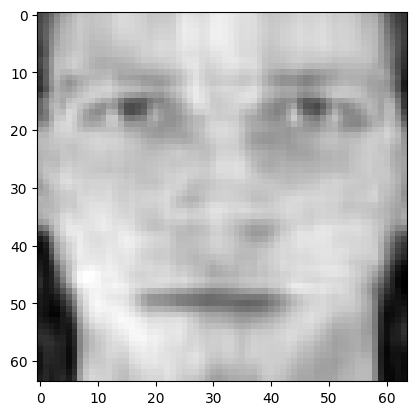

In [211]:
# calculating CP decomp of tensor of all images
x_cp = tl.decomposition.parafac(x, rank = 100)

# random shit to calculate the norm etc
print(tl.cp_tensor.cp_norm(x_cp))
print(tl.norm(x, order = 1))
print(np.shape(x_cp))
print(np.shape(tl.cp_tensor.cp_to_tensor(x_cp)))


final_cp_tensor = tl.cp_tensor.cp_to_tensor(x_cp)
imshow(final_cp_tensor[0], cmap = 'gray')

Mean squared error between x and the final tensor: 1.6743424803832503e-13


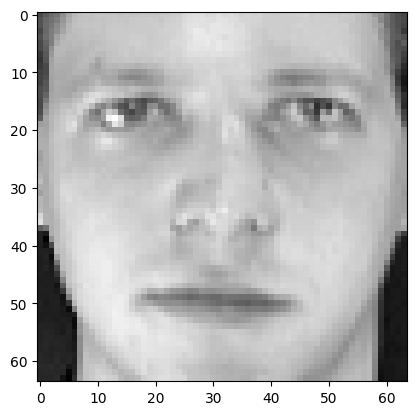

In [214]:
#Tucker Decomposition here
core, factors = tl.decomposition.tucker(x, rank=[40, 64, 64])
final_tucker_tensor = tl.tucker_to_tensor((core, factors))
mse = tl.norm(final_tucker_tensor - x, 2) ** 2 / tl.norm(x, 2) ** 2
print("Mean squared error between x and the final tensor:", mse)
imshow(final_tucker_tensor[0], cmap = 'gray')

In [146]:
mse2 = tl.norm(final_tucker_tensor - final_cp_tensor, 2) ** 2 / tl.norm(x, 2) ** 2
print("Mean squared error between cp and tucker decomposition:", mse2)


Mean squared error between cp and tucker decomposition: 0.006555447889638317


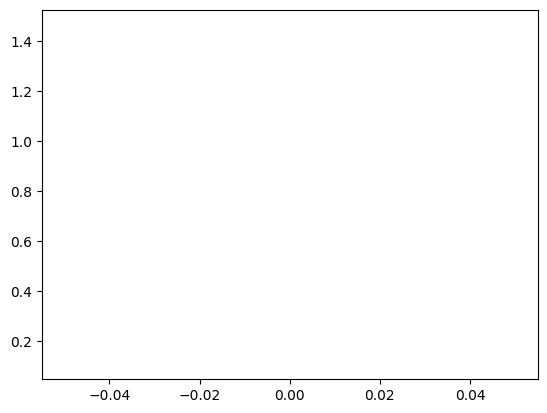

In [198]:
variances = []
components = []

pca2 = PCA(n_components = 1)


for i in range(40):
    pca2.fit(final_cp_tensor[i])
    variances.append(pca2.explained_variance_)
    components.append(pca2.components_)

variances = np.asarray(variances).T
components = np.asarray(components).T

plt.plot(variances)
plt.show()
    

In [199]:
print(np.shape(variances))

(1, 40)


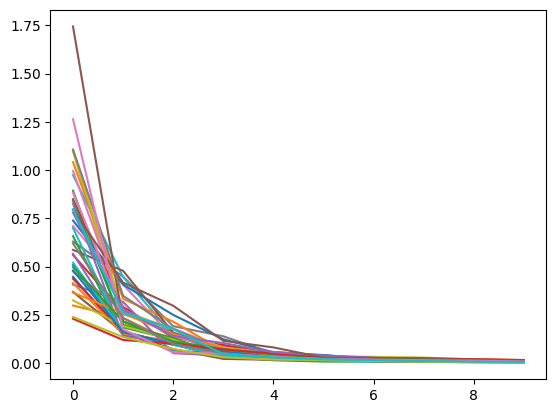

In [138]:
variances2 = []
components2 = []

pca3 = PCA(n_components = 10)


for i in range(40):
    pca3.fit(x[i])
    variances2.append(pca3.explained_variance_)
    components2.append(pca3.components_)

variances2 = np.asarray(variances2).T
components2 = np.asarray(components2).T

plt.plot(variances2)
plt.show()

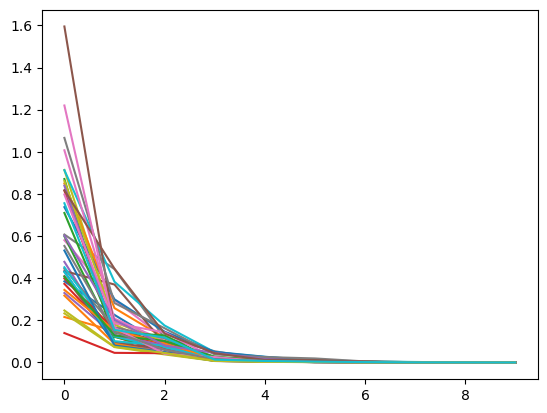

In [188]:
variances3 = []
components3 = []

pca4 = PCA(n_components = 10)


for i in range(40):
    pca4.fit(final_tucker_tensor[i])
    variances3.append(pca4.explained_variance_)
    components3.append(pca4.components_)

variances3 = np.asarray(variances3).T
components3 = np.asarray(components3).T

plt.plot(variances3)
plt.show()

In [187]:
print(np.shape(components.T))
print(np.shape(components.T[:][0][0]))

print(components.T[0][0][0])


(40, 10, 64)
(64,)
-0.08515553
